# Implementing with filtering and thresholding

For now inherit the ugly LSM class and inherit it in the Filter class (to be changed later). Operate with the LSM class to obtain the first rgb.tiff output.

Filter class has the median filter and otsu thresolding as an initial test

In [34]:

import os
from skimage.external import tifffile as tf
import numpy as np
import scipy.signal
from skimage import data, filters
import matplotlib.pyplot as plt # plt.imshow()


def main():
    os.chdir("/home/c/Documents/Academic/BI3002 Biosciences Erasmus "
             "Placement Research Project/CellCounter")
    tifobj = tf.TiffFile("testack.lsm")
    arr = tifobj.asarray()
    return arr


class LSM:

    def __init__(self):
        self.red_sum = {}
        self.green_sum = {}
        self.blue_sum = {}
        self.red_max = {}
        self.green_max = {}
        self.blue_max = {}

    def project_channel_sum(channelid):
        """ Takes a 6 dimensions tiff array and projects the Z axis into X, Y.
        Uses the max intensity value of each Z slice.
        """
        arr = main()
        channel_sum = np.zeros((512, 512), dtype=np.int8)
        for i in range(0, np.size(arr, 2)):
            channel_sum = np.add(channel_sum, arr[0, 0, i, channelid, :, :])
        # Normalize, first 0 - 1, then to max = 255 (uint8)
        channel_sum = channel_sum.astype(np.float64) / channel_sum.max()
        channel_sum = 255 * channel_sum
        channel_sum = channel_sum.astype(np.uint8)
        return channel_sum

    def project_channel_max(channelid):
        """ Takes a 6 dimensions tiff array and projects the Z axis into X, Y.
        Uses the max intensity value of each Z slice.
        """
        arr = main()
        channel_max = np.zeros((512, 512), dtype=np.int8)
        for i in range(0, np.size(arr, 2)):
            channel_max = np.fmax(channel_max, arr[0, 0, i, channelid, :, :],
                                  dtype=np.int8)
        # Normalize, first 0 - 1, then to max = 255
        channel_max = channel_max.astype(np.float64) / channel_max.max()
        channel_max = 255 * channel_max
        channel_max = channel_max.astype(np.uint8)
        return channel_max

    red_sum = project_channel_sum(0)
    green_sum = project_channel_sum(1)
    blue_sum = project_channel_sum(2)

    red_max = project_channel_max(0)
    green_max = project_channel_max(1)
    blue_max = project_channel_max(2)


lsm1 = LSM

rgb = np.dstack([lsm1.red_max,    # R
                 lsm1.green_max,  # G
                 lsm1.blue_max])  # B

rgb = np.moveaxis(rgb, -1, 0)

tf.imsave('rgb.tiff', rgb)


class Filter(LSM):

    def __init__(self):
        pass

    def median_filter(volume):
        filtered = scipy.signal.medfilt(volume)
        return filtered

    def otsu_thesholding(image):
        thresholded = image > filters.threshold_otsu(image)
        return thresholded


arr = main()


Let's show the original DAPI channel from the z projected image to compare with the filtered version:

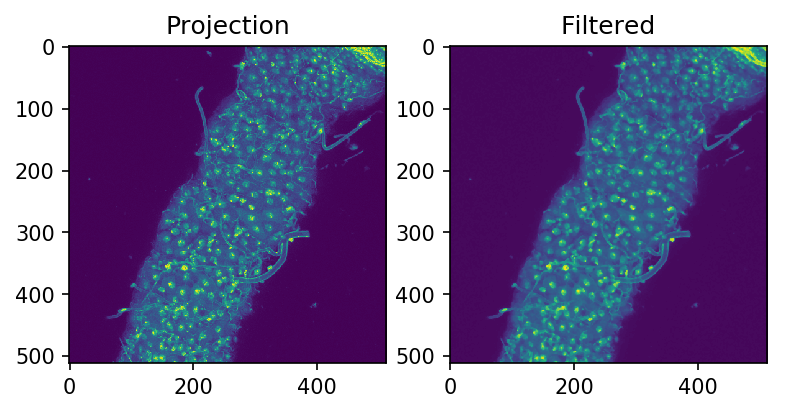

In [35]:
projected = rgb[2,:,:]

arr = main()
lsm1 = Filter
filtered = lsm1.median_filter(rgb[2,:,:])


fig, ax = plt.subplots(nrows=1, ncols=2, dpi=150)

ax[0].imshow(projected)
ax[0].set_title('Projection')

ax[1].imshow(filtered)
ax[1].set_title('Filtered')

plt.show()

Roughness is indeed reduced



Now plot first otsu thresholded image:

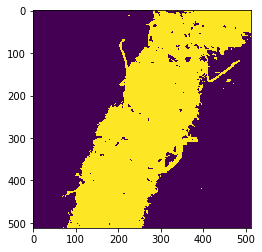

In [36]:
thresholded = lsm1.otsu_thesholding(filtered)
plt.imshow(thresholded)

Output is not very beautiful nor informative, I tried different approaches before swapping to another method. As the otsu function only returns a value to be used in the actual thresholding oeration, it may be used to generate dynamic thresholding behavior inside other functions. I explored another basic thresholding, hysteresis thresholding:

http://scikit-image.org/docs/stable/auto_examples/filters/plot_hysteresis.html#sphx-glr-auto-examples-filters-plot-hysteresis-py

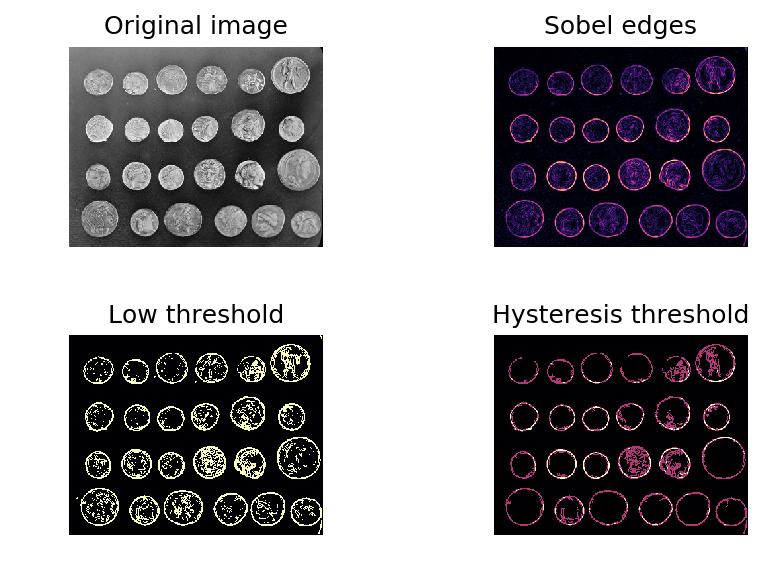

In [37]:

fig, ax = plt.subplots(nrows=2, ncols=2, dpi=150)

image = data.coins()
edges = filters.sobel(image)

low = 0.1
high = 0.35

lowt = (edges > low).astype(int)
hight = (edges > high).astype(int)
hyst = filters.apply_hysteresis_threshold(edges, low, high)

ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Original image')

ax[0, 1].imshow(edges, cmap='magma')
ax[0, 1].set_title('Sobel edges')

ax[1, 0].imshow(lowt, cmap='magma')
ax[1, 0].set_title('Low threshold')

ax[1, 1].imshow(hight + hyst, cmap='magma')
ax[1, 1].set_title('Hysteresis threshold')

for a in ax.ravel():
    a.axis('off')

plt.tight_layout()

plt.show()

Hysteresis thresholding need an array and two vales as input. As not all images look overall the same, a fixed threshold will not likely work for all of them. Hysteresis thresholding could be made more "image-sensitive" combined with otsu filtering.

The following code will find out the otsu threshold for an area with reduced background (this was just a rough test), apply a +70% otsu threshold as the minimum for the hysteresis thresholding function. The maximum for hystheresis thresholding will be dynamically determined by the maximum intensity of the filtered image (-45% of that value).

Also, would it make any difference to try and work with the raw z-project?

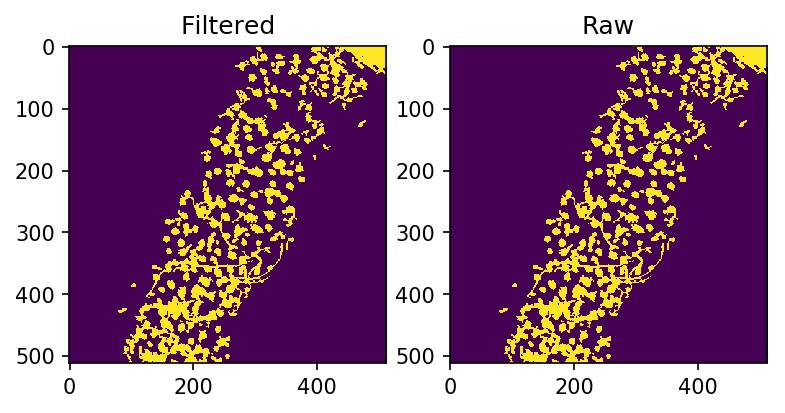

In [38]:
processed1 = filters.apply_hysteresis_threshold(
        filtered,filters.threshold_otsu(filtered[:, 150:350]) * 1.7,
        np.max(filtered) * 0.55)

processed2 = filters.apply_hysteresis_threshold(
        filtered, filters.threshold_otsu(filtered[:, 150:350]) * 1.7,
        np.max(filtered) * 0.55)

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=150)
ax[0].imshow(processed1)
ax[0].set_title('Filtered')

ax[1].imshow(processed2)
ax[1].set_title('Raw')

plt.show()

Better but still far from reality. I tried some operations about changing otsu value for a number obtained playing with the median in certain image regions but results were worse. It looks like working with the unfiltered image is not worth it.

Playing with hysteresis min and max argument value multiplier can get a better result. However, will this fine tunning translate into other images?